
Training (with validation) and fine-tuning for neural model: LSTM
Loaded existing model for LSTM from best_model_LSTM_4d.pt


/tmp/ipykernel_1659000/1624898663.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))



Training (with validation) and fine-tuning for neural model: GRU
Loaded existing model for GRU from best_model_GRU_4d.pt


/tmp/ipykernel_1659000/1624898663.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))



Training (with validation) and fine-tuning for neural model: RNN
Loaded existing model for RNN from best_model_RNN_4d.pt


/tmp/ipykernel_1659000/1624898663.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))



Training (with validation) and fine-tuning for neural model: CNN
Loaded existing model for CNN from best_model_CNN_4d.pt


/tmp/ipykernel_1659000/1624898663.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


Loaded existing SVM model from best_model_SVM_4d.pt
Loaded existing BOOST model from best_model_BOOST_4d.pt


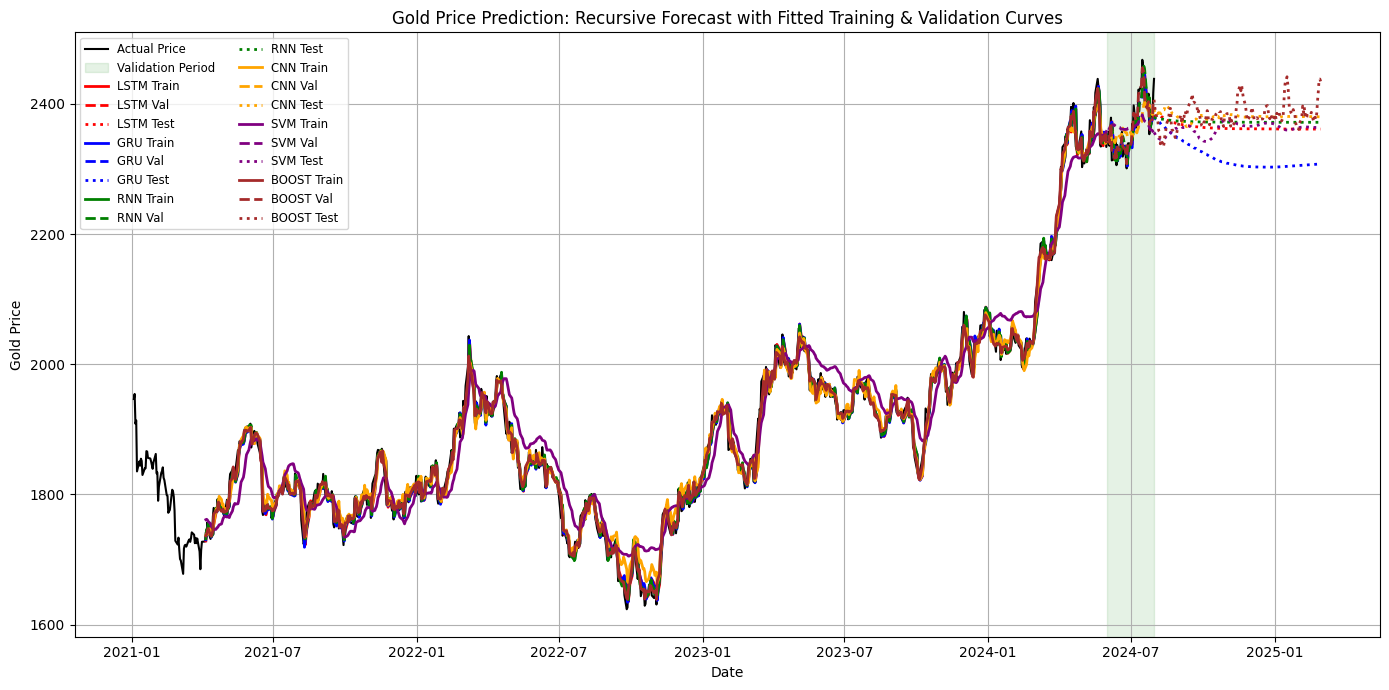

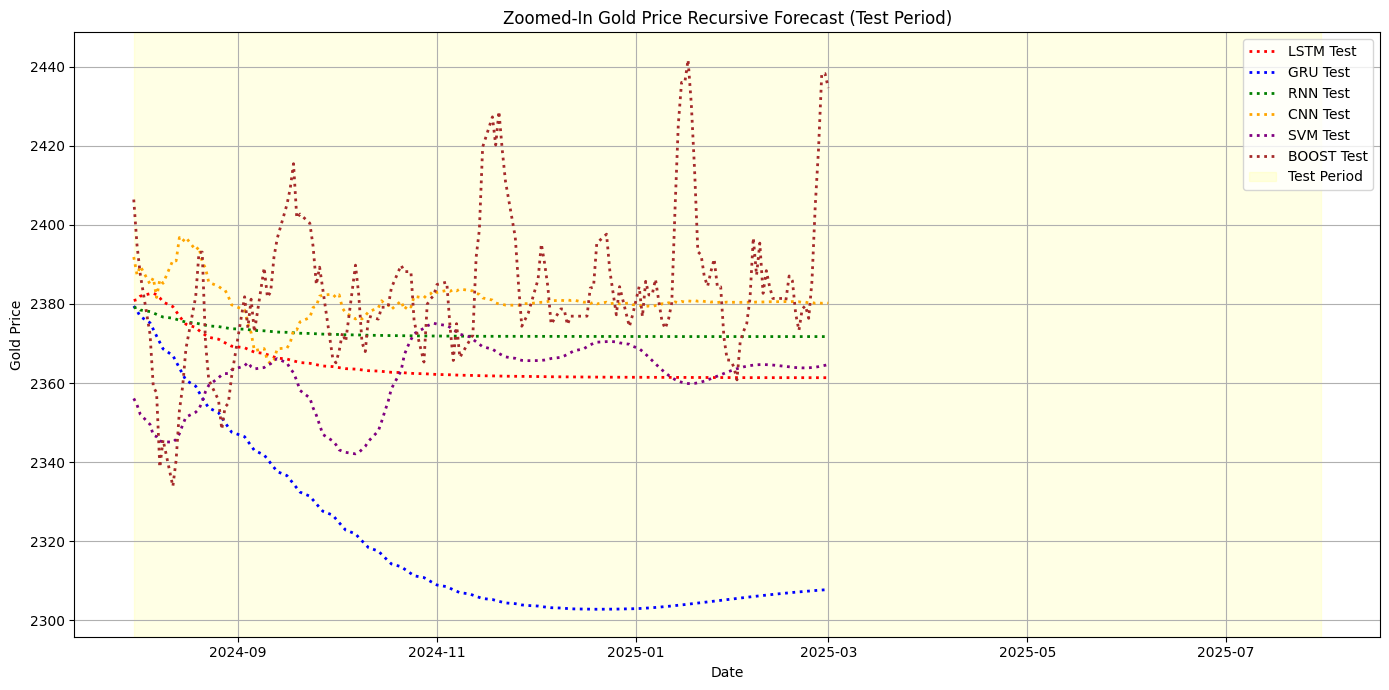

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import matplotlib.dates as mdates
import joblib  # For saving/loading scikit-learn models

# For SVM and Boosting:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

### DATA LOADING, CLEANING, AND PREPARATION ###
df = pd.read_csv('Gold Futures Historical Data_3Yr_Train.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform columns to numerical format
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Features to include
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Data scaling: scale all four features using MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Window width (number of past days used for prediction)
window_width = 65  # adjust as needed

# Prepare sequences:
# Each sample: the previous window_width days (shape: (window_width, 4))
# Target: the 4-dimensional vector of the day immediately following.
X, y, all_dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])
    y.append(data_scaled[i])
    all_dates.append(df['Date'].iloc[i])

X = np.array(X)  # shape: (num_samples, window_width, 4)
y = np.array(y)  # shape: (num_samples, 4)
all_dates = np.array(all_dates)

# --- Split data into training, validation, and test sets ---
# Training: dates before 2024-06-01.
# Validation: dates from 2024-06-01 (inclusive) to 2024-07-31 (non-inclusive).
# Test: dates from 2024-07-31 to 2025-03-01.
train_mask = all_dates < pd.to_datetime('2024-06-01')
val_mask   = (all_dates >= pd.to_datetime('2024-06-01')) & (all_dates < pd.to_datetime('2024-07-31'))
test_mask  = (all_dates >= pd.to_datetime('2024-07-31')) & (all_dates <= pd.to_datetime('2025-03-01'))

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val     = X[val_mask], y[val_mask]
X_test, y_test   = X[test_mask], y[test_mask]
train_dates = all_dates[train_mask]
val_dates   = all_dates[val_mask]
test_dates  = all_dates[test_mask]

# Convert to PyTorch tensors (for the NN models)
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor   = torch.from_numpy(X_val).float()
y_val_tensor   = torch.from_numpy(y_val).float()
X_test_tensor  = torch.from_numpy(X_test).float()
y_test_tensor  = torch.from_numpy(y_test).float()

# Create TensorDatasets and DataLoaders for training and validation
batch_size = 32  # adjust as needed
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader    = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### MODEL DEFINITION (NEURAL NETWORK MODELS) ###
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        input_size = len(features)  # 4 features
        
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)
            
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)
            
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)
            
        elif model_type == 'CNN':
            # Hybrid model: LSTM -> Convolutions -> Fully Connected Layers
            
            # LSTM layer to capture long-term dependencies
            self.lstm = nn.LSTM(
                input_size=input_size,
                hidden_size=128,
                num_layers=1,
                batch_first=True
            )
            # Convolutional layers on top of LSTM output:
            # LSTM output shape: (batch, window_width, 128)
            # We need to permute it to (batch, channels, seq_length) for Conv1d.
            self.conv1 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
            self.pool1 = nn.MaxPool1d(kernel_size=2)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
            self.pool2 = nn.MaxPool1d(kernel_size=2)
            
            # After two pooling layers (each with kernel size 2), the sequence length is reduced by a factor of 4.
            conv_output_length = window_width // 4  
            
            # Fully connected layers for the final mapping
            self.fc1 = nn.Linear(32 * conv_output_length, 50)
            self.dropout = nn.Dropout(0.2)
            self.fc2 = nn.Linear(50, input_size)
        else:
            raise ValueError("Invalid model_type. Choose from 'LSTM', 'GRU', 'RNN', 'CNN'")

    def forward(self, x):
        if self.model_type == 'CNN':
            # x shape: (batch, window_width, 4)
            
            # 1. LSTM layer: outputs shape (batch, window_width, 128)
            lstm_out, _ = self.lstm(x)
            
            # 2. Rearrange dimensions for Conv1d: (batch, channels, seq_length)
            x_conv = lstm_out.permute(0, 2, 1)
            
            # 3. Convolution and pooling layers
            x_conv = F.relu(self.conv1(x_conv))
            x_conv = self.pool1(x_conv)
            x_conv = F.relu(self.conv2(x_conv))
            x_conv = self.pool2(x_conv)
            
            # 4. Flatten and pass through fully connected layers
            x_conv = x_conv.view(x_conv.size(0), -1)
            x_fc = F.relu(self.fc1(x_conv))
            x_fc = self.dropout(x_fc)
            out = self.fc2(x_fc)
        else:
            # For other model types, follow the existing architecture
            out, _ = self.rnn(x)
            out = out[:, -1, :]  # Use the output from the last time step
            out = self.fc(out)
        return out  # Expected output shape: (batch, 4)


### EARLY STOPPING CLASS ###
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
            
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

### TRAINING FUNCTION FOR NEURAL MODELS ###
def train_and_evaluate(model_name, train_loader, val_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BaseModel(model_type=model_name).to(device)
    
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 1500
    best_val_loss = float('inf')
    
    best_model_path = f'best_model_{model_name}_4d.pt'
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")
    else:
        for epoch in range(num_epochs):
            model.train()
            train_losses = []
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                preds = model(X_batch)
                loss = criterion(preds, y_batch)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
            avg_train_loss = np.mean(train_losses)
            
            # Evaluate on validation set:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    preds = model(X_batch)
                    loss = criterion(preds, y_batch)
                    val_losses.append(loss.item())
            avg_val_loss = np.mean(val_losses)
            
            scheduler.step(avg_val_loss)
            early_stopping(avg_val_loss)
            if early_stopping.early_stop:
                print(f"[{model_name}] Early stopping at epoch {epoch + 1}")
                break
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), best_model_path)
            if (epoch + 1) % 100 == 0 or epoch == 0:
                print(f'[{model_name}] Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
        model.load_state_dict(torch.load(best_model_path, map_location=device))
    return model

# --- Fine-tuning function: retrain on training+validation data ---
def fine_tune_nn(model, X_train_val_tensor, y_train_val_tensor, num_epochs=50, lr=0.0002):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.train()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.HuberLoss()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        preds = model(X_train_val_tensor.to(device))
        loss = criterion(preds, y_train_val_tensor.to(device))
        loss.backward()
        optimizer.step()
    return model

### RECURSIVE FORECASTING FUNCTIONS ###
def recursive_forecast(model, initial_window, forecast_horizon, device):
    """
    Recursively forecast the next 'forecast_horizon' days using a PyTorch model.
    """
    model.eval()
    preds = []
    current_window = initial_window.clone().to(device)
    for _ in range(forecast_horizon):
        input_tensor = current_window.unsqueeze(0)
        with torch.no_grad():
            pred = model(input_tensor)
        pred = pred.squeeze(0)
        preds.append(pred.cpu().numpy())
        current_window = torch.cat((current_window[1:], pred.unsqueeze(0)), dim=0)
    return np.array(preds)

def recursive_forecast_sklearn(model, initial_window, forecast_horizon):
    """
    Recursively forecast the next 'forecast_horizon' days using a scikit-learn model.
    """
    current_window = initial_window.copy()
    preds = []
    for _ in range(forecast_horizon):
        X_input = current_window.flatten().reshape(1, -1)
        pred = model.predict(X_input)
        pred = pred.flatten()
        preds.append(pred)
        current_window = np.vstack((current_window[1:], pred))
    return np.array(preds)

### PREDICTION FUNCTIONS FOR ONE-STEP (FITTED) VALUES ###
def predict_nn(model, X_tensor, device):
    model.eval()
    with torch.no_grad():
        preds = model(X_tensor.to(device)).cpu().numpy()
    preds_inv = scaler.inverse_transform(preds)
    return preds_inv

def predict_sklearn(model, X, flatten=True):
    # X is expected in its original shape (n_samples, window_width, 4)
    if flatten:
        X_flat = X.reshape(X.shape[0], -1)
    else:
        X_flat = X
    preds = model.predict(X_flat)
    preds_inv = scaler.inverse_transform(preds)
    return preds_inv

### TRAIN AND PREDICT WITH NEURAL NETWORK MODELS ###
neural_model_names = ['LSTM', 'GRU', 'RNN', 'CNN']
predictions_all = {}  # will hold predictions for 'train', 'val', 'test' for each model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Also form the training+validation set for fine-tuning:
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)
X_train_val_tensor = torch.from_numpy(X_train_val).float()
y_train_val_tensor = torch.from_numpy(y_train_val).float()

for model_name in neural_model_names:
    print(f"\nTraining (with validation) and fine-tuning for neural model: {model_name}")
    # Train using training and validation (with early stopping)
    model = train_and_evaluate(model_name, train_loader, val_loader)
    # Fine-tune on combined training+validation set:
    model = fine_tune_nn(model, X_train_val_tensor, y_train_val_tensor, num_epochs=50, lr=0.0002)
    
    # Compute one-step predictions (fitted values) for training and validation:
    train_preds = predict_nn(model, X_train_tensor, device)
    val_preds   = predict_nn(model, X_val_tensor, device)
    # For test forecasting, use recursive forecasting.
    # Use the last window from the training+validation set (which are actual values) as the starting window.
    initial_window_nn = torch.from_numpy(X_train_val[-1]).float()
    forecast_horizon = len(test_dates)
    test_preds_rec = recursive_forecast(model, initial_window_nn, forecast_horizon, device)
    test_preds_rec_inv = scaler.inverse_transform(test_preds_rec)
    
    predictions_all[model_name] = {
        'train': train_preds[:, 0],  # predicted Price (first column)
        'val':   val_preds[:, 0],
        'test':  test_preds_rec_inv[:, 0]
    }

### TRAIN AND PREDICT WITH SVM AND BOOSTING MODELS (scikit-learn) ###
# For these, we now train on the combined training+validation data.
X_train_val_flat = np.concatenate((X_train, X_val), axis=0).reshape(-1, window_width*4)
y_train_val_flat = np.concatenate((y_train, y_val), axis=0)

# --- SVM ---
svm_model_path = 'best_model_SVM_4d.pt'
if os.path.exists(svm_model_path):
    svr = joblib.load(svm_model_path)
    print(f"Loaded existing SVM model from {svm_model_path}")
else:
    svr = MultiOutputRegressor(SVR(kernel='rbf'))
    svr.fit(X_train_val_flat, y_train_val_flat)
    joblib.dump(svr, svm_model_path)
    
# One-step predictions for training and validation (flatten inputs):
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
train_preds_svm = predict_sklearn(svr, X_train, flatten=True)
val_preds_svm   = predict_sklearn(svr, X_val, flatten=True)
# For test forecasting, use recursive forecasting with the last window from training+validation.
X_train_val_np = np.concatenate((X_train, X_val), axis=0)
initial_window_np = X_train_val_np[-1]  # shape: (window_width, 4)
svr_test_rec = recursive_forecast_sklearn(svr, initial_window_np, len(test_dates))
svr_test_rec_inv = scaler.inverse_transform(svr_test_rec)

predictions_all['SVM'] = {
    'train': train_preds_svm[:, 0],
    'val':   val_preds_svm[:, 0],
    'test':  svr_test_rec_inv[:, 0]
}

# --- BOOSTING ---
boost_model_path = 'best_model_BOOST_4d.pt'
if os.path.exists(boost_model_path):
    gbr = joblib.load(boost_model_path)
    print(f"Loaded existing BOOST model from {boost_model_path}")
else:
    gbr = MultiOutputRegressor(GradientBoostingRegressor(random_state=0))
    gbr.fit(X_train_val_flat, y_train_val_flat)
    joblib.dump(gbr, boost_model_path)
    
train_preds_boost = predict_sklearn(gbr, X_train, flatten=True)
val_preds_boost   = predict_sklearn(gbr, X_val, flatten=True)
boost_test_rec = recursive_forecast_sklearn(gbr, initial_window_np, len(test_dates))
boost_test_rec_inv = scaler.inverse_transform(boost_test_rec)

predictions_all['BOOST'] = {
    'train': train_preds_boost[:, 0],
    'val':   val_preds_boost[:, 0],
    'test':  boost_test_rec_inv[:, 0]
}

### PLOTTING RESULTS ###
# First, get the actual prices (inverse-transformed) for the whole dataset.
all_prices_inv = scaler.inverse_transform(data_scaled)[:, 0]

# Define colors for each model.
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'SVM': 'purple',
    'BOOST': 'brown'
}

plt.figure(figsize=(14, 7))
plt.plot(df['Date'], all_prices_inv, color='black', label='Actual Price')

# Shade the validation period (2024-06-01 to 2024-07-31) with shallow green.
plt.axvspan(pd.to_datetime('2024-06-01'), pd.to_datetime('2024-07-31'),
            color='green', alpha=0.1, label='Validation Period')

# For each model, plot:
# - One-step predictions (fitted values) for the training period (solid line)
# - One-step predictions for the validation period (dashed line)
# - Recursive forecast for the test period (dotted line)
for model_name, preds in predictions_all.items():
    plt.plot(train_dates, preds['train'], color=model_colors.get(model_name, 'grey'),
             linestyle='-', linewidth=2, label=f'{model_name} Train')
    plt.plot(val_dates, preds['val'], color=model_colors.get(model_name, 'grey'),
             linestyle='--', linewidth=2, label=f'{model_name} Val')
    plt.plot(test_dates, preds['test'], color=model_colors.get(model_name, 'grey'),
             linestyle=':', linewidth=2, label=f'{model_name} Test')

plt.title('Gold Price Prediction: Recursive Forecast with Fitted Training & Validation Curves')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend(loc='best', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

# (Optionally, you can also zoom in on the test period if desired.)
plt.figure(figsize=(14, 7))
for model_name, preds in predictions_all.items():
    plt.plot(test_dates, preds['test'], color=model_colors.get(model_name, 'grey'),
             linestyle=':', linewidth=2, label=f'{model_name} Test')
plt.title('Zoomed-In Gold Price Recursive Forecast (Test Period)')
plt.xlabel('Date')
plt.ylabel('Gold Price')
# Highlight the test period.
plt.axvspan(pd.to_datetime('2024-07-31'), df['Date'].iloc[-1], color='yellow', alpha=0.1, label='Test Period')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()
